In [1]:
using JuMP, GLPK, Distances, IterTools, Random, Plots, Clustering

In [2]:
function is_tsp_solved(m, x; benchmark=false)
    N = size(x)[1]
    x_val = JuMP.value.(x)
    
    # find cycle
    cycle_idx = Int[]
    push!(cycle_idx, 1)
    while true
        v, idx = findmax(x_val[cycle_idx[end],1:N])
        if idx == cycle_idx[1]
            break
        else
            push!(cycle_idx,idx)
        end
    end
    if !benchmark
        println("cycle_idx: ", cycle_idx)
        println("Length: ", length(cycle_idx))
    end
    if length(cycle_idx) < N
        @constraint(m, sum(x[cycle_idx,cycle_idx]) <= length(cycle_idx)-1)
        return false
    end
    return true
end 

is_tsp_solved (generic function with 1 method)

In [3]:
function solve_tsp(position)
    
    Nprob = size(position)[1] + 1
    NposNew = BasePos
    for i in position
        NposNew = [NposNew ; Npos[i,1] Npos[i,2]]
    end
    #println(NposNew)
    dist_mat = zeros(Nprob,Nprob)
    for i=1:Nprob, j=i+1:Nprob
        i_pos = [NposNew[i,1], NposNew[i,2]]
        j_pos = [NposNew[j,1], NposNew[j,2]]
        d = euclidean(i_pos, j_pos)
        dist_mat[i,j] = d
        dist_mat[j,i] = d
    end
    if size(position)[1] == 1
        return 2*dist_mat[1,2], position
    end
    #println(dist_mat)
    m = Model(with_optimizer(GLPK.Optimizer))
    @variable(m, x[1:Nprob,1:Nprob], Bin)
    @objective(m, Min, sum(x[i,j]*dist_mat[i,j] for i=1:Nprob,j=1:Nprob))
    for i=1:Nprob 
        @constraint(m, x[i,i] == 0)
        @constraint(m, sum(x[i,1:Nprob]) == 1)
    end
    for j=1:Nprob
        @constraint(m, sum(x[1:Nprob,j]) == 1)
    end
    for f=1:Nprob, t=1:Nprob
        @constraint(m, x[f,t]+x[t,f] <= 1)
    end
    
    optimize!(m)
   
    while !is_tsp_solved(m, x; benchmark=true)
        optimize!(m)
    end
    
    #println("Obj: ", JuMP.objective_value(m))

    if JuMP.termination_status(m) == MOI.OPTIMAL
        optimal = 1
    else
        optimal = 0
    end
    
    # find cycle
    x_res = JuMP.value.(x)
    position_cycle = []
    posI = 1
    posF = 0
    while posF != 1
        posF = findall(isequal(1), x_res[posI,:])[1]
        if posF != 1
            push!(position_cycle, position[posF-1])
        end
        posI = posF
    end

    #println(JuMP.objective_value(m))
    
    return JuMP.objective_value(m), position_cycle
end

solve_tsp (generic function with 1 method)

In [4]:
function binRoute(i)
    r_j = []
    for w=1:N
        if w in i
            push!(r_j,1)
        else
            push!(r_j,0)
        end
    end
    return r_j
end

binRoute (generic function with 1 method)

In [5]:
function create_routes(Rmax, N, q, V, Ves, Ncluster, nofCluster)
    r = []
    r_cycle = []
    D = [] # Duration of voyage r on vessel v: D = ones(V,R)*2
    a = [] # 1 if vessel v visits installation i on voyage r 
    distM = []
    for nclust=1:nofCluster
        for j=1:minimum([size(Ncluster[nclust])[1], Rmax])
            for i in subsets(Ncluster[nclust], j)
                q_sum = sum(q[q_i] for q_i in i)

                r_j = binRoute(i)
                push!(r, r_j)
                r_size = size(r)[1]

                dist_r, cycle = solve_tsp(i)
                push!(r_cycle, cycle)

                for v_i=1:V
                    if q_sum <= Ves[v_i][3]
                        push!(D, Int(ceil(dist_r/Ves[v_i][4])))
                        push!(distM, dist_r)
                    else
                        push!(D, 0)
                        push!(distM, 0)
                    end
                end

                for n_i=1:N
                    for v_i=1:V
                        if q_sum <= Ves[v_i][3]
                            push!(a, r[r_size][n_i])
                        else
                            push!(a, 0)
                        end
                    end
                end

            end
        end
    end
    a = reshape(a, V, N, size(r)[1])
    D = reshape(D, V, size(r)[1])
    distM = reshape(distM, V, size(r)[1])
    l = sort(unique(D))[2:end]
    L = size(l)[1]
    R = size(r)[1]
    
    return a, D, distM, l, L, r, r_cycle, R
end

create_routes (generic function with 1 method)

In [6]:
function create_Rv(D, V, R)
    Rv = []
    Rv_i = []
    for v=1:V
        Rv_i = []
        for r=1:R
            if D[v,r] != 0
                push!(Rv_i, r)
            end 
        end
        push!(Rv, Rv_i)
    end
    return Rv
end

create_Rv (generic function with 1 method)

In [7]:
function mod_modified(time, T)
    if mod(time,T) == 0
        return T
    else
        return mod(time,T)
    end
end

mod_modified (generic function with 1 method)

In [8]:
function create_offshoreUnits(N, nofCluster, maxC, minC)
    
    Npos = rand!(rng, zeros(N,2))
    Npos[:,1] = Npos[:,1]*80
    Npos[:,2] = Npos[:,2]*10
    
    it = 1
    if nofCluster == 1
        return Npos, Array[1:N]
    else
        kmeansCluster = kmeans(Npos', nofCluster)
        clusterSize = counts(kmeansCluster)
        while (maximum(clusterSize) > maxC) | (minimum(clusterSize) < minC)
            println("it: ", it)
            if (it>20)
                break
            end
            kmeansCluster = kmeans(Npos', nofCluster)
            clusterSize = counts(kmeansCluster)
            println("max: ", maximum(clusterSize))
            println("min: ", minimum(clusterSize))
            it = it+1
        end

        Ncluster = assignments(kmeansCluster)

        clusters = []
        for i=1:nofCluster
            i_cluster = []
            for j=1:N
                if Ncluster[j] == i
                    push!(i_cluster, j)
                end
            end
            push!(clusters, i_cluster)
        end

        return Npos, clusters
    end
    
end

create_offshoreUnits (generic function with 1 method)

In [9]:
function create_vessels(Vkind)
    VesInit = 0
    Ves = []
    FixedCost = []
    for vk_i=1:size(Vkind)[1]
        for v=1:Vkind[vk_i, 4]
           if VesInit == 0
                Ves = [[1 Vkind[vk_i, 1] Vkind[vk_i, 2] Vkind[vk_i, 3]]]
                VesInit = 1
            else
                push!(Ves, [(Ves[size(Ves)[1]][1] + 1) Vkind[vk_i, 1] Vkind[vk_i, 2] Vkind[vk_i, 3]])
            end
            push!(FixedCost, Vkind[vk_i, 5])
        end
    end
    return Ves, FixedCost
end

create_vessels (generic function with 1 method)

In [10]:
function optimizeRoutes(V, R, T, L, FixedCost, distM, a, l, B, f, D, Rv, tmax)
    m = Model(with_optimizer(GLPK.Optimizer, tm_lim = tmax))
    #m = Model(with_optimizer(Gurobi.Optimizer, TimeLimit = tmax))
    @variable(m, d[1:V], Bin)
    @variable(m, x[1:V, 1:R, 1:T], Bin)


    @objective(m, Min, sum(FixedCost[v]*d[v] for v=1:V) + sum(distM[v,r]*x[v,r,t] for v=1:V, r=1:R, t=1:T))

    for i=1:N
        @constraint(m, sum(a[v,i,r]*x[v,r,t] for v=1:V, r=1:R, t=1:T) == s[i])
    end

    for v=1:V
        @constraint(m, sum(D[v,r]*x[v,r,t] - f[v]*d[v] for r in Rv[v], t=1:T) <= 0)
    end

    for t=1:T
        @constraint(m, sum(x[v,r,t] for v=1:V, r in Rv[v]) <= B[t])
    end

    for v=1:V
        for t=1:T
            for i=1:L
                Rvl = Vector{Int64}()
                for y=1:R
                    if D[v,y] == l[i]
                        push!(Rvl, y)
                    end
                end
                @constraint(m, sum(x[v,r,t] for r in Rvl) + sum(x[v,r,mod_modified(t+tb,T)] for r in Rv[v], tb=1:(l[i]-1)) <= 1)
            end
        end
    end


    optimize!(m)

    if JuMP.termination_status(m) == MOI.OPTIMAL
        optimal = 1
    else
        optimal = 0
    end
    println(optimal)
    println("Obj: ", JuMP.objective_value(m))
    println("Vessels: ", JuMP.value.(d))
    
    return JuMP.value.(x)
end


optimizeRoutes (generic function with 1 method)

In [11]:
function preparePlot(x_val, a, r_cycle, BasePos, Npos, r, Ncluster, nofCluster)

    x_pos = []
    y_pos = []
    u_vec = []
    v_vec = []
    colors = [:blue, :green, :yellow, :black, :blue, :green, :yellow, :black]
    
    marker_pos = []
    color_pos = []
    color_vec = []

    for t=1:T
        tPlan = findall(isequal(1), x_val[:,:,t])
        for t_rn=1:size(tPlan)[1]

            ves = tPlan[t_rn][1]
            route = tPlan[t_rn][2]
            push!(color_vec, colors[ves])
            
            if size(findall(isequal(1), a[ves,:,route]))[1] != 0
                @show route
                @show r[route]
                cyc_route = pushfirst!(copy(r_cycle[route]), 0)
                soma = size(cyc_route)[1]


                push!(x_pos, BasePos[1])
                push!(y_pos, BasePos[2])
                push!(marker_pos, :rect)
                push!(color_pos, :red)

                for i=2:soma
                    push!(x_pos, Npos[cyc_route[i],1])
                    push!(y_pos, Npos[cyc_route[i],2])
                    push!(marker_pos, :circle)
                    for clus=1:nofCluster
                        if size(findall(isequal(cyc_route[i]), Ncluster[clus]))[1] != 0
                            push!(color_pos, colors[clus])
                        end
                    end
                end

                vec_size = size(u_vec)[1]
                vec_soma = vec_size + soma

                for i=(vec_size+1):vec_soma
                    if i == vec_soma
                        push!(u_vec, x_pos[1] - x_pos[vec_soma])
                        push!(v_vec, y_pos[1] - y_pos[vec_soma])
                    else
                        push!(u_vec, x_pos[i+1]-x_pos[i])
                        push!(v_vec, y_pos[i+1]-y_pos[i])
                    end  
                end
            end
        end
    end
    return x_pos, y_pos, u_vec, v_vec, marker_pos, color_pos, color_vec

end

preparePlot (generic function with 1 method)

In [12]:
rng = MersenneTwister(1234);
Rmax = 5 # max nof offshore installations on a single route
T = 7 # planning horizon

# Vessel Kind and creation of vessels
# Vkind = [1=id_kind, 2=capacity, 3=speed, 4=quantity_available, 5=fixed_cost]
# FixedCost is the cost of each vessel
Vkind = [1 150 60 5 600; 2 250 45 5 800]
Ves, FixedCost = create_vessels(Vkind)
V = size(Ves)[1]

f = ones(V)*T # nof days vessel v can be used during the week
B = ones(T)*2 # nof vessels that may be serviced at the supply depot

N = 8 # nof offshore installations
nofCluster = 3 # nof clusters of offshore installations
s = ones(N) # nof weekly visits to installation i
q = rand(20:80, N) # demand of installation i
Npos, Ncluster = create_offshoreUnits(N, nofCluster, 999, 2)
BasePos = [0.0 5.0];

a, D, distM, l, L, r, r_cycle, R = create_routes(Rmax, N, q, V, Ves, Ncluster, nofCluster);

Rv = create_Rv(D, V, R);




┌ Warning: `with_optimizer` is deprecated. Adapt the following example to update your code:
│ `with_optimizer(Ipopt.Optimizer)` becomes `Ipopt.Optimizer`.
│   caller = solve_tsp(::Array{Any,1}) at In[3]:21
└ @ Main .\In[3]:21


┌ Warning: `with_optimizer` is deprecated. Adapt the following example to update your code:
│ `with_optimizer(Ipopt.Optimizer, max_cpu_time=60.0)` becomes `optimizer_with_attributes(Ipopt.Optimizer, "max_cpu_time" => 60.0)`.
│   caller = ip:0x0
└ @ Core :-1


0
Obj: 1690.536515295804
Vessels: [0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0]
route = 7
r[route] = Any[1, 0, 1, 1, 0, 0, 0, 0]
route = 17
r[route] = Any[0, 0, 0, 0, 0, 0, 1, 1]
route = 14
r[route] = Any[0, 1, 0, 0, 1, 1, 0, 0]


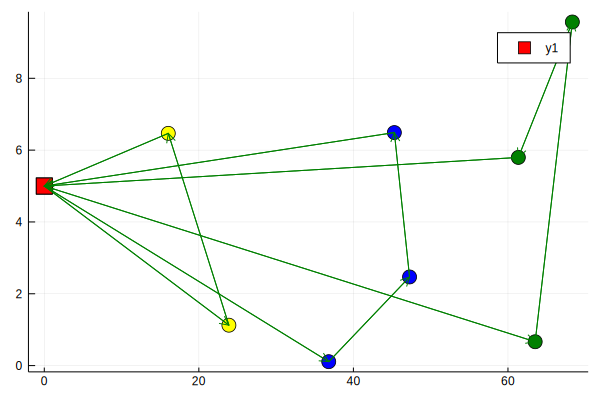

In [13]:
tmax = 60000;
x_val = optimizeRoutes(V, R, T, L, FixedCost, distM, a, l, B, f, D, Rv, tmax);

x_pos, y_pos, u_vec, v_vec, marker_pos, color_pos,color_vec = preparePlot(x_val, a, r_cycle, BasePos, Npos, r, Ncluster, nofCluster)

scatter(x_pos,y_pos,marker=8,markershape=marker_pos, color=color_pos)
quiver!(x_pos,y_pos,quiver=(u_vec,v_vec), color=:green)